<a href="https://colab.research.google.com/github/ananyas168/RL/blob/main/n_arm_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1

### Individual plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

def plot_history(history):
  rewards = history["rewards"]
  cum_rewards = history["cum_rewards"]
  chosen_arms = history["arms"]

  fig = plt.figure(figsize=[30,8])

  ax2 = fig.add_subplot(121)
  ax2.plot(cum_rewards, label="avg rewards")
  ax2.set_title("Cummulative Rewards")

  ax3 = fig.add_subplot(122)
  ax3.bar([i for i in range(len(chosen_arms))], chosen_arms, label="chosen arms")
  ax3.set_title("Chosen Actions")

###enviornment

In [ ]:
import numpy as np 

class bandit_env():
    """
    Initialize the multi-arm bandit environment.
    :params:
    r_mean: takes a list of reward mean
    r_stddev: takes a list of reward standard deviation
    """
    def __init__(self, r_mean, r_stddev):
        if len(r_mean) != len(r_stddev):
            raise ValueError("Reward distribution parameters (mean and variance) must be of the same length")

        if any(r <= 0 for r in r_stddev):
            raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.n = len(r_mean)
        self.r_mean = r_mean
        self.r_stddev = r_stddev

    def pull(self, index_arm):
        """
        Performs the action of pulling the arm/lever of the selected bandit
        :inputs:
        index_arm: the index of the arm/level to be pulled
        :outputs:
        reward: the reward obtained by pulling tht arm (sampled from their corresponding Gaussian distribution)
        """
        reward = np.random.normal(self.r_mean[index_arm], self.r_stddev[index_arm])
        return reward

In [ ]:
env = bandit_env([2.5, -3.5, 1.0, 5.0, -2.5],[0.33, 1.0, 0.66, 1.98, 1.65])


### random Agent

In [ ]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=2000):
    self.env = env
    self.iterations = max_iterations

  def act(self):
    arm_counts = np.zeros(self.env.n)
    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.n)
      reward = self.env.pull(arm)

      arm_counts[arm] += 1
      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

In [ ]:
random_agent = RandomAgent(env=env, max_iterations=2000)
ra_history = random_agent.act()
print(f"TOTAL REWARD : {sum(ra_history['rewards'])}")

TOTAL REWARD : 869.641276897541


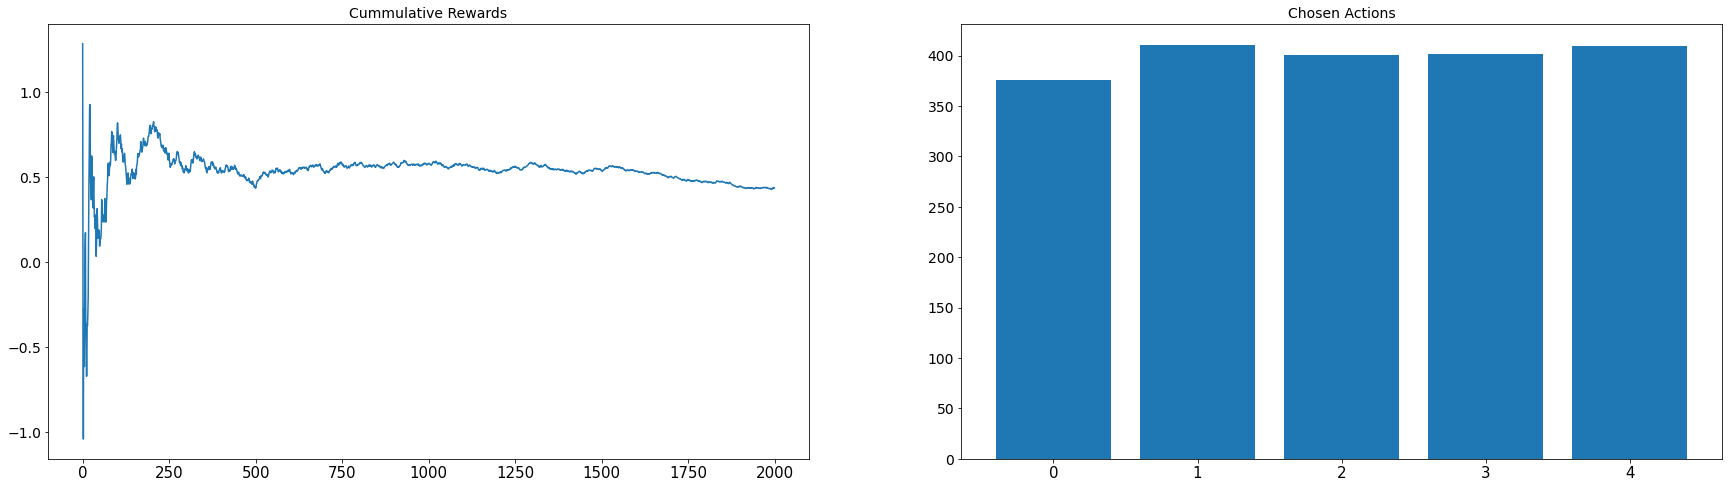

In [ ]:
plot_history(ra_history)

### epsilon Greedy Agent

In [ ]:
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations=2000, epsilon=0.01):     #, decay=0.001, decay_interval=50):
    self.env = env 
    self.iterations = max_iterations
    self.epsilon = epsilon 
    # self.decay = decay 
    # self.decay_interval = decay_interval

  def act(self):
    q_values = np.zeros(self.env.n)
    arm_rewards = np.zeros(self.env.n)
    arm_counts = np.zeros(self.env.n)

    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.n) if np.random.random() < self.epsilon else np.argmax(q_values)
      reward = self.env.pull(arm)

      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]

      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

      # if i % self.decay_interval == 0:
      #   self.epsilon = self.epsilon * self.decay 

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

TOTAL REWARD : 44986.02823805184


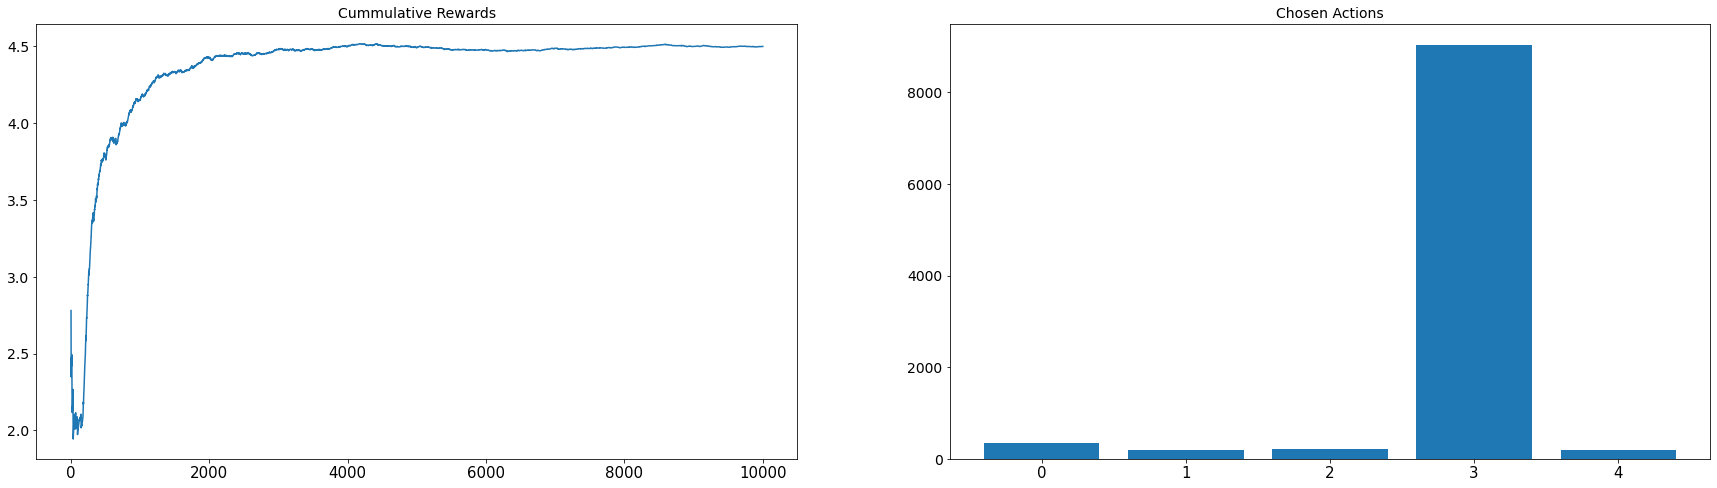

In [ ]:
egreedy_agent = EpsilonGreedyAgent(env, max_iterations=10000, epsilon=0.1)
eg_history = egreedy_agent.act()
print(f"TOTAL REWARD : {sum(eg_history['rewards'])}")
plot_history(eg_history)

### greedy wuth optimal initialization

In [ ]:
class Greedy_Optimal_Agent(object):

  def __init__(self, env, max_iterations=2000, q0 = 0, alpha = 0.1):
    self.env = env 
    self.iterations = max_iterations
    self.q0 = q0
    self.alpha = 0.1

  def act(self):
    q_values = np.zeros(self.env.n)+ self.q0
    arm_rewards = np.zeros(self.env.n)
    arm_counts = np.zeros(self.env.n)

    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.n) if np.random.random() < 0.001 else np.argmax(q_values)
      reward = self.env.pull(arm)
      
      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]
      #q_values[arm] = q_values[arm]+ self.alpha*(reward - q_values[arm])

      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

TOTAL REWARD : 2515.2352115029516


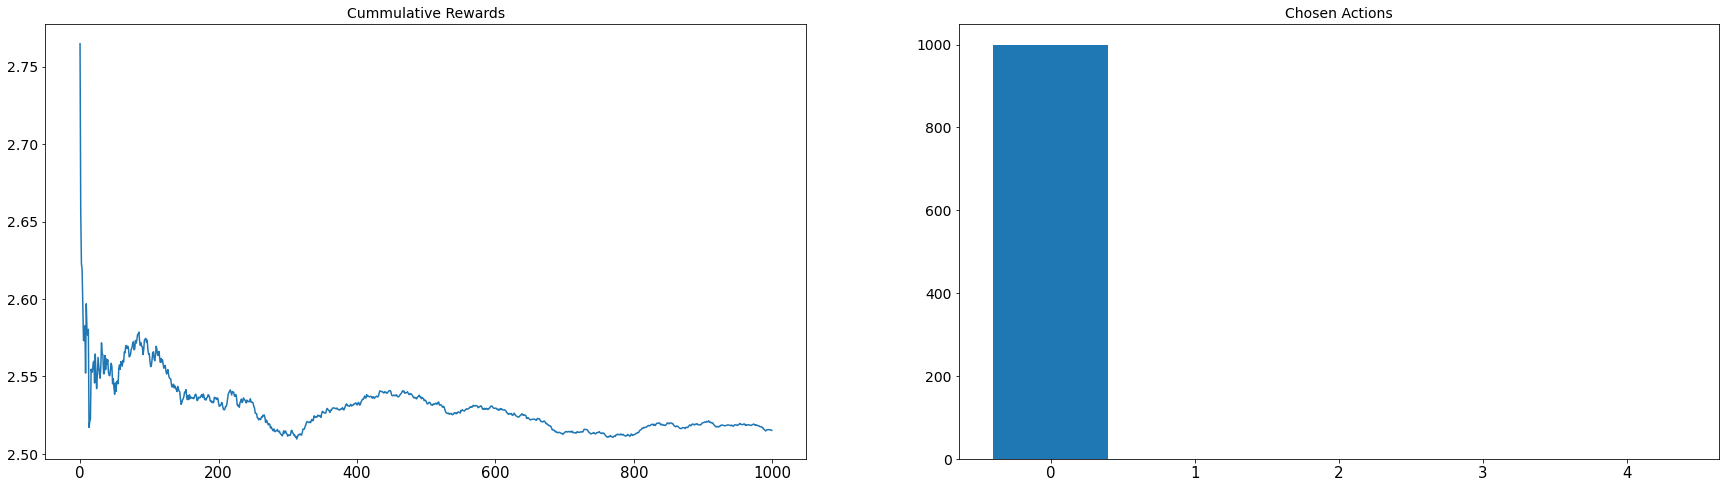

In [ ]:
greedy_optimal_agent = Greedy_Optimal_Agent(env, max_iterations=1000,q0=1)
greedy_optimal_history = greedy_optimal_agent.act()
print(f"TOTAL REWARD : {sum(greedy_optimal_history['rewards'])}")
plot_history(greedy_optimal_history)

### UCB Agent

In [ ]:
class UCBAgent(object):

  def __init__(self, env, max_iterations= 2000, c = 0.1):
    self.env = env 
    self.iterations = max_iterations
    self.c = c
   
  def act(self):
    q_values = np.zeros(self.env.n)
    arm_rewards = np.zeros(self.env.n)
    arm_counts = np.zeros(self.env.n)
    arm_selected = []

    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      # policy = q_values + self.c* math.sqrt(2 * math.log(i+1) / arm_counts)
      # arm = np.argmax(policy)

      arm_init= 0
      max_bound =0

      for arm in range(self.env.n):
        if (arm_counts[arm] > 0):
            average_reward = arm_rewards[arm] / arm_counts[arm]
            delta_arm = math.sqrt(2 * math.log(i+1) / arm_counts[arm])
            upper_bound = average_reward + self.c * delta_arm
        else:
            upper_bound = 1e400
        
        if upper_bound > max_bound:
            max_bound = upper_bound
            arm_init = arm

      arm_selected.append(arm_init)
      arm_counts[arm_init] += 1
      reward = self.env.pull(arm_init)
      arm_rewards[arm_init] += reward
      arm_counts[arm_init] += 1
      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

       

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

TOTAL REWARD : 9957.908437548884


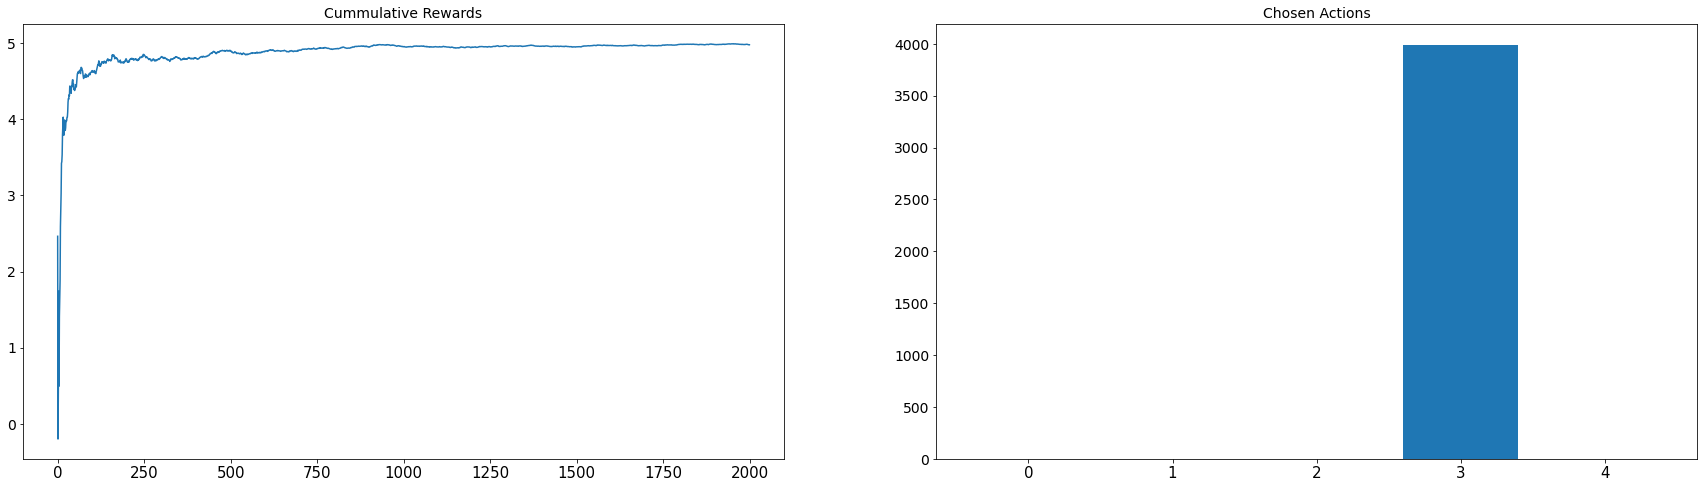

In [ ]:
UCB_agent = UCBAgent(env, max_iterations=2000, c=.02)
ucb_history = UCB_agent.act()
print(f"TOTAL REWARD : {sum(ucb_history['rewards'])}")
plot_history(ucb_history)

### Gradient Bandit Agent

In [ ]:
def softmax(H):
    h = H - np.max(H)
    exp = np.exp(h)
    return exp / np.sum(exp)

class Gradient_Bandit_Agent(object):

  def __init__(self, env, max_iterations=2000, alpha =0.1):
    self.env = env 
    self.iterations = max_iterations
    self.alpha = alpha 
    

  def act(self):
    H = np.zeros(self.env.n)
    arm_rewards = np.zeros(self.env.n)
    arm_counts = np.zeros(self.env.n)

    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      policy = softmax(H)
      arm = np.random.choice(self.env.n, p = policy) 
      reward = self.env.pull(arm)
      
      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))
      #print('reward{}---avg_reward{}--policy{}---arm{}'.format(reward,np.average(rewards), policy,arm))
      #print('add', self.alpha*(reward-np.average(rewards))*(1-policy[arm]))
      H[arm] =  H[arm] + self.alpha*(reward-np.average(rewards))*(1-policy[arm])
      H[:arm] =  H[:arm] + self.alpha*(reward-np.average(rewards))*(policy[:arm])
      H[arm+1:] =  H[arm+1:] + self.alpha*(reward-np.average(rewards))*(policy[arm+1:])
      #print(H)

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards, 'H':H}

TOTAL REWARD : 7121.791522271042
[-34.91203287 -36.3263631  -35.32288628 -34.50638791 -36.20776588]


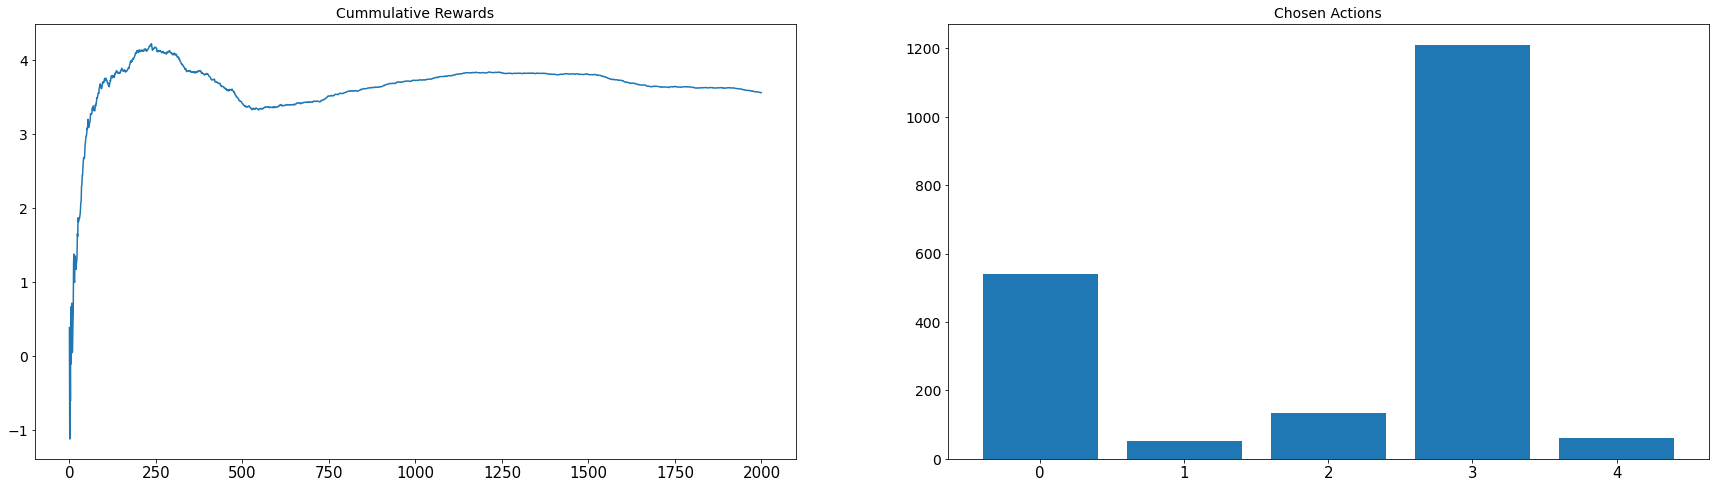

In [ ]:
GB_agent = Gradient_Bandit_Agent(env, max_iterations=2000, alpha = 0.1)
gb_history = GB_agent.act()
print(f"TOTAL REWARD : {sum(gb_history['rewards'])}")
plot_history(gb_history)
print(gb_history['H'])

### Final Plot

[Text(0, 0, '1/128'),
 Text(0, 0, '1/64'),
 Text(0, 0, '1/32'),
 Text(0, 0, '1/16'),
 Text(0, 0, '1/8'),
 Text(0, 0, '1/4'),
 Text(0, 0, '1/2'),
 Text(0, 0, '1'),
 Text(0, 0, ' 2'),
 Text(0, 0, '4')]

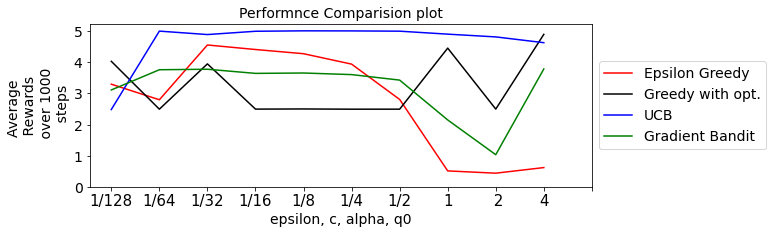

In [ ]:
# the overall plot:
import numpy as np

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

# large = 22; med = 16; small = 12
# params = {'axes.titlesize': med,
#           'legend.fontsize': med,
#           'figure.figsize': (16, 10),
#           'axes.labelsize': med,
#           'axes.titlesize': med,
#           'xtick.labelsize': 15,
#           'ytick.labelsize': med,
#           'figure.titlesize': med}

large = 22; med = 14; small = 12
params = {'axes.titlesize': med,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': 15,
          'ytick.labelsize': med,
          'figure.titlesize': med}

plt.rcParams.update(params)
#plt.style.use('seaborn-whitegrid')
#sns.set_style("whitegrid")
#sns.set_style("white")
#%matplotlib inline
e_greedy_list= []
e_greedy_optimal_list = []
UCB_list= []
gradient_bandit_list = []
x_grad = np.array([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4])
for i in x_grad:
  e_greedy_list.append(sum(EpsilonGreedyAgent(env, max_iterations=1000, epsilon=i).act()['rewards'])/1000)
  e_greedy_optimal_list.append(sum(Greedy_Optimal_Agent(env, max_iterations=1000,q0=i).act()['rewards'])/1000)
  UCB_list.append(sum(UCBAgent(env, max_iterations=1000, c=i).act()['rewards'])/1000)
  gradient_bandit_list.append(sum(Gradient_Bandit_Agent(env, max_iterations=1000, alpha =i).act()['rewards'])/1000)
  




fig, ax = plt.subplots(figsize=(9,3))#, dpi= 800)
ax.plot(e_greedy_list, color = 'red', label='Epsilon Greedy')
ax.plot(e_greedy_optimal_list, color = 'black', label='Greedy with opt.')
ax.plot(UCB_list,color = 'blue', label = 'UCB')
ax.plot(gradient_bandit_list, color = 'green', label = 'Gradient Bandit')
ax.set_xticks(np.arange(10+1))
ax.set_yticks(np.arange(6))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
#ax.set_ylim(0,6)
ax.set_title('Performnce Comparision plot')
ax.set_ylabel('Average \n Rewards \n over 1000\n steps')
ax.set_xlabel('epsilon, c, alpha, q0')
ax.set_xticklabels(['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1',' 2', '4'])


# ax3 = fig.add_subplot(122)
# ax3.bar([i for i in range(len(chosen_arms))], chosen_arms, label="chosen arms")
# ax3.set_title("Chosen Actions")

#Question 2

### Picture of transitions

### The Table
 Consiting transition state and prob with reward.

In [ ]:
table = [['H','H','class', 0.5, -1],['H','AB','class',0.5,+3],['H','C','class',0,],['H','C','hungry',1,+1],['H','AB','hungry',0,],['H','H','hungry',0,],
         ['AB','AB','class',0.7,+3],['AB','C','class',0.3,+1],['AB','H','class',0,],['AB','AB','hungry',0.2,+3],['AB','C','hungry',0.8,+1],['AB','H','hungry',0,],
         ['C','AB','class',0.6,+3],['C','H','class',0.3,-1],['C','C','class',0.1,+1],['C','H','hungry',0,],['C','AB','hungry',0,],['C','C','hungry',1,+1]]
import pandas as pd
import numpy as np
table = pd.DataFrame(table) 
table.columns = ['state0','state1','action','prob','reward']
table        

,state0,state1,action,prob,reward
0,H,H,class,0.5,-1.0
1,H,AB,class,0.5,3.0
2,H,C,class,0.0,NaN
3,H,C,hungry,1.0,1.0
4,H,AB,hungry,0.0,NaN
5,H,H,hungry,0.0,NaN
6,AB,AB,class,0.7,3.0
7,AB,C,class,0.3,1.0
8,AB,H,class,0.0,NaN
9,AB,AB,hungry,0.2,3.0


In [ ]:
table = table.fillna(0)


Description about the enviorment:
I havent created a class for the enviorment  used te functionality of pandas to get the required subset of the data.

At each leevl of screening I have generated a sub_table, sub_sub_table, sub_sub_sub_table based on the required condition.
Hope the code is readable. 
Please let me knoe if you need any description

### Value Iteration

In [ ]:
def one_step_lookahead(table, state, V, discount_factor):
        #action_values = np.zeros(len(table.action.unique()))
        action_values = {a:0 for a in table.action.unique() }
        sub_table = table[table.state0 == state]
        for action in sub_table.action.unique():
                sub_sub_table = sub_table[sub_table.action == action]
                for next_state in sub_sub_table.state1.unique():
                          sub_sub_sub_table = sub_sub_table[sub_sub_table.state1 == next_state]
                          action_values[action] += sub_sub_sub_table.prob.to_numpy()[0] * (sub_sub_sub_table.reward.to_numpy()[0] + discount_factor * V[next_state])
                         
        return action_values


In [ ]:
#final Value iretration:

discount_factor=0.85
theta=1e-9
max_iterations=2000
# Initialize state-value function with zeros for each environment state
V = {s:0 for s in table.state0.unique()}
#print(V)
for i in range(int(max_iterations)):
        # Early stopping condition
        delta = 0
        # Update each state
        for state in table.state0.unique():
                # Do a one-step lookahead to calculate state-action values
                action_value = one_step_lookahead(table, state, V, discount_factor)
                # Select best action to perform based on the highest state-action value
                best_action_value = np.max(list(action_value.values()))
                delta = max(delta, np.abs(V[state] - best_action_value))
                #print('delta',delta)
                # Update the value function for current state
                V[state] = best_action_value
                # Check if we can stop
        if delta < theta:
                print(f'Value-iteration converged at iteration #{i}.')
                print('\nOptimal Value state function after {}th iteration is:\n\n {} \n'.format(i,V))
                
                break
#print('\nOptimal Value state function after {}th iteration is:\n\n {} \n'.format(i,V))


# Create a deterministic policy using the optimal value function

policy = {s:{a:0 for a in table.action.unique()} for s in table.state0.unique()}
for state in table.state0.unique():
        # One step lookahead to find the best action for this state
        action_value = one_step_lookahead(table, state, V, discount_factor)
        #print('action_value,',action_value)
        # Select best action based on the highest state-action value
        best_action = max(action_value, key= lambda x: action_value[x]) 
        #print('best_action',best_action)
        # Update the policy to perform a better action at a current state
        policy[state][best_action] = 1
        
#print(policy)        
df_policy = pd.DataFrame(policy)#, index = ['Hostel', 'Acadmic_Building','Canteen'], columns = table.action.unique())        
print('Policy After value ietration: \n',df_policy.T)

Value-iteration converged at iteration #108.

Optimal Value state function after 108th iteration is:

 {'H': 12.173765710178365, 'AB': 14.117447727372294, 'C': 13.010064040425757} 

Policy After value ietration: 
     class  hungry
H       1       0
AB      1       0
C       1       0


### Policy Iteration

In [ ]:
#POLICY EVALUATION
#final one
def policy_evaluation(policy, table, discount_factor=0.85,theta=1e-9,max_iterations=20000):
          # Number of evaluation iterations
          evaluation_iterations = 1
        
          # Initialize a value function for each state as zero
          V = {s:0 for s in table.state0.unique()}
          
          # Repeat until change in value is below the threshold
          for i in range(int(max_iterations)):
                  # Initialize a change of value function as zero
                  delta = 0
                  # Iterate though each state
                  for state in table.state0.unique():
                          # Initial a new value of current state
                          v = 0
                          sub_table = table[table.state0 == state]
                          # Try all possible actions which can be taken from this state
                          for action in sub_table.action.unique():
                                # Check how good next state will be
                                sub_sub_table = sub_table[ sub_table.action == action]
                                for next_state in sub_sub_table.state1.to_numpy():
                                    # Calculate the expected value
                                    #print('state--{},    action---{},     next_state----{}'.format(state, action, next_state))
                                    sub_sub_sub_table = sub_sub_table[sub_sub_table.state1 == next_state]
                                    #print('sub_sub_sub_table:\n',sub_sub_sub_table)
                                    #print('v',0.5 * sub_sub_sub_table.prob.to_numpy()[0] * (sub_sub_sub_table.reward.to_numpy()[0] + discount_factor * V[next_state]))          
                                    v += policy[state][action] * sub_sub_sub_table.prob.to_numpy()[0] * (sub_sub_sub_table.reward.to_numpy()[0] + discount_factor * V[next_state])
                                    #print('vv', v)
                          #print('v------',v)          

                          # Calculate the absolute change of value function
                          delta = max(delta, np.abs(V[state] - v))
                          # Update value function
                          V[state] = v
                          #print('V-----------',V)
                          # print('\ndelta----',delta)
                  evaluation_iterations += 1
                  # print('--'*50)
                  # print('\n')
                  # print('\n')
                  # print('iteration_no:',i)
                  
                  # Terminate if value change is insignificant
                  if delta < theta:
                          print(f'Policy evaluated in {evaluation_iterations} iterations.')
                          #print(V)
                          #break
                          return V

In [ ]:
# POLICY ITERATION
discount_factor= 0.85
max_iterations=1e9
# Start with a random policy
#num states x num actions / num actionst 
policy = {s:{a : 1/len(table.action.unique()) for a in table.action.unique()} for s in table.state0.unique()}
# Initialize counter of evaluated policies
evaluated_policies = 1
# Repeat until convergence or critical number of iterations reached
for i in range(int(max_iterations)):
        stable_policy = True
        # Evaluate current policy
        V = policy_evaluation(policy, table, discount_factor=discount_factor)
        # Go through each state and try to improve actions that were taken (policy Improvement)
        for state in table.state0.unique():
                # Choose the best action in a current state under current policy
                current_action =  max(policy[state], key= lambda x: policy[state][x]) #np.argmax(policy[state])
                # Look one step ahead and evaluate if current action is optimal
                # We will try every possible action in a current state
                action_value =  one_step_lookahead(table, state, V, discount_factor)
                # Select a better action
                best_action = max(action_value, key= lambda x: action_value[x])
                # If action didn't change
                #print('state---{}, current_action---{}, action_value---{}, best_action---{}'.format(state, current_action, action_value, best_action))
                if current_action != best_action:
                        print('iam here')
                        stable_policy = False
                        # Greedy policy update
                        policy[state][best_action] = 1.0
                        policy[state][list(set(table.action.unique())-set([best_action]))[0]] = 0.0
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if stable_policy:
                print(f'Evaluated {evaluated_policies} policies.')
                policy_df = pd.DataFrame(policy)
                print('\nOptimal Value state function after   {}: \n'.format(V))
                print('Policy obtained after Policy iteration:\n',policy_df.T)
                
                break                          

Policy evaluated in 103 iterations.
Evaluated 2 policies.

Optimal Value state function after   {'H': 9.255519556134564, 'AB': 10.358406831809228, 'C': 9.617788704496935}: 

Policy obtained after Policy iteration:
     class  hungry
H     0.5     0.5
AB    0.5     0.5
C     0.5     0.5
